In [2]:
# Import packages
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import calendar
months = [month.lower() for month in calendar.month_name[1:]]

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [33]:
year = 2023

url = f'https://www.basketball-reference.com/leagues/NBA_{year}_ratings.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
soup.find('tr', class_='over_header').decompose()
table = soup.find('table')
teams_dict = pd.read_html(str(table))[0][['Team', 'W', 'L']]
teams_dict['code'] = [x['href'].split('/')[2] for x in table.find_all('a', href = True)]
ngames_dict = dict(zip(teams_dict['code'], teams_dict['W'] + teams_dict['L']))
teams_dict  = dict(zip(teams_dict['Team'], teams_dict['code']))

url = f'https://www.basketball-reference.com/leagues/NBA_{year}_games.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
monthly_url = [x['href'] for x in soup.find_all('a', href = True) if x['href'].split('.html')[0].split('-')[-1] in months]
while soup.find('tr', class_ = 'thead') is not None:
    soup.find('tr', class_ = 'thead') .decompose()

games = pd.read_html(str(soup.find('table')))[0]

for m_url in monthly_url[1:]:

    url = 'https://www.basketball-reference.com/' + m_url
    soup = BeautifulSoup(requests.get(url).content, 'lxml')
    m_games = pd.read_html(str(soup.find('table')))[0]
    games = pd.concat([games, m_games])

games = games.rename(columns = {'Start (ET)':'Time', 'Visitor/Neutral':'Away', 'Home/Neutral':'Home', 'PTS':'PTS_away', 'PTS.1':'PTS_home'})
games['Date'] = games['Date'] + games['Time'].apply(lambda x: ' ' + x[:-1] + x[-1].upper() + 'M')
games['Date'] = pd.to_datetime(games['Date'])
games = games[['Date', 'Home', 'Away', 'PTS_home', 'PTS_away']]
games = games.sort_values('Date').reset_index(drop = True)
games['Home'] = games['Home'].apply(lambda x: teams_dict.get(x))
games['Away'] = games['Away'].apply(lambda x: teams_dict.get(x))

In [111]:
homes, aways = [], []

for tm in list(teams_dict.values()) :

    print(tm)

    games_tm = games.copy()[(games['Home'] == tm) | (games['Away'] == tm)]
    games_tm['Home?'] = 1 * (games_tm['Home'] == tm)
    games_tm['Opponent'] = (games_tm['Home?'] * games_tm['Away'] + (1 - games_tm['Home?']) * games_tm['Home'])
    games_tm['PTS'] = (games_tm['Home?'] * games_tm['PTS_home'] + (1 - games_tm['Home?']) * games_tm['PTS_away'])
    games_tm['PTS_opp'] = (games_tm['Home?'] * games_tm['PTS_away'] + (1 - games_tm['Home?']) * games_tm['PTS_home'])
    games_tm['W'] = (games_tm['PTS'] > games_tm['PTS_opp']).astype(int)
    games_tm['Team'] = len(games_tm) * [tm]
    games_tm = games_tm.head(ngames_dict.get(tm))
    games_tm = games_tm.sort_values('Date').reset_index(drop = True)
    games_tm['G'] = games_tm.index + 1
    games_tm = games_tm[['Date', 'Team', 'Opponent', 'G', 'Home?', 'PTS', 'PTS_opp', 'W']]

    features = []
    games_tm['NRtg'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(1000, min_periods = 1).mean().shift(1)
    features.append('NRtg')
    for lag in [5, 10, 25] :
        games_tm[f'NRtg_{lag}'] = (games_tm['PTS'] - games_tm['PTS_opp']).rolling(lag, min_periods = 1).mean().shift(1)
        features.append(f'NRtg_{lag}')

    games_tm['W/L'] = games_tm['W'].rolling(1000, min_periods = 1).mean().shift(1)
    features.append('W/L')
    for lag in [5, 10, 25] :
        games_tm[f'W/L_{lag}'] = games_tm['W'].rolling(lag, min_periods = 1).mean().shift(1)
        features.append(f'W/L_{lag}')

    games_tm['Streak'] = streak(games_tm['W'].replace(0, -1))
    features.append('Streak')

    games_tm['Rest'] = (games_tm['Date'] - games_tm['Date'].shift(1)).apply(lambda x: x.total_seconds() / (24 * 3600))
    features.append('Rest')

    games_tm_home = games_tm.groupby('Home?').get_group(1)
    for f in ['G', 'W'] + features :
        games_tm_home = games_tm_home.rename(columns = {f : f + '_home'})
    games_tm_home = games_tm_home.rename(columns = {'Team': 'Home', 'Opponent': 'Away', 'PTS': 'PTS_home', 'PTS_opp': 'PTS_away'})

    games_tm_away = games_tm.groupby('Home?').get_group(0)
    for f in ['G', 'W'] + features :
        games_tm_away = games_tm_away.rename(columns = {f : f + '_away'})
    games_tm_away = games_tm_away.rename(columns = {'Team': 'Away', 'Opponent': 'Home', 'PTS': 'PTS_away', 'PTS_opp': 'PTS_home'})

    homes.append(games_tm_home)
    aways.append(games_tm_away)

BOS
CLE
PHI
MEM
MIL
NYK
DEN
SAC
PHO
TOR
NOP
GSW
CHI
BRK
OKC
LAL
ATL
LAC
DAL
MIN
MIA
UTA
WAS
ORL
IND
POR
CHO
HOU
DET
SAS


In [109]:
def streak(results_list) :

    streak_type, current_res = results_list[0], results_list[0]
    streak = 1
    streaks = [results_list[0]]
    for res in results_list[1:] :
        if res == current_res:
            streak += 1
        else :
            streak = 1
            streak_type = res
        streaks.append(streak * streak_type)
        current_res = res
        
    return [np.nan] + streaks[:-1]

In [112]:
# Get all home stats and away stats in single DataFrame
homes_df = pd.concat(homes).drop(columns = 'Home?')
aways_df = pd.concat(aways).drop(columns = ['Home?'])
    
# Merge away and home games on the unique game ID
data = homes_df.merge(aways_df, on = ['Date', 'Home', 'Away', 'PTS_home', 'PTS_away'])
data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
data = data.sort_values('Date').reset_index(drop = True)

In [115]:
for f in features :

    data[f] = data[f + '_home'] - data[f + '_away']
    data = data.drop(columns = [f + '_home', f + '_away'])

In [116]:
data

,Date,Home,Away,G_home,PTS_home,PTS_away,W_home,G_away,W_away,PTS_diff,NRtg,NRtg_5,NRtg_10,NRtg_25,W/L,W/L_5,W/L_10,W/L_25,Streak,Rest
0,2022-10-18 19:30:00,BOS,PHI,1,126,117,1,1,0,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-10-18 22:00:00,GSW,LAL,1,123,109,1,1,0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-10-19 19:00:00,IND,WAS,1,107,114,0,1,1,-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022-10-19 19:00:00,DET,ORL,1,113,109,1,1,0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022-10-19 19:30:00,BRK,NOP,1,108,130,0,1,1,-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,2023-04-09 15:30:00,LAL,UTA,82,128,117,1,82,0,11,1.259259,13.8,14.3,8.08,0.061728,0.6,0.6,0.28,0.0,0.708333
1226,2023-04-09 15:30:00,PHO,LAC,82,114,119,0,82,1,-5,1.716049,4.6,1.8,2.96,0.024691,0.2,0.1,0.08,-3.0,0.729167
1227,2023-04-09 15:30:00,DEN,SAC,82,109,95,1,82,0,14,0.345679,-8.4,-4.2,-2.44,0.049383,-0.2,0.0,-0.08,-1.0,-0.729167
1228,2023-04-09 15:30:00,POR,GSW,82,101,157,0,82,1,-56,-4.506173,-20.4,-20.4,-14.52,-0.123457,-0.6,-0.5,-0.36,-5.0,-0.750000


In [37]:
url = 'https://www.basketball-reference.com/teams/NYK/2023_games.html'
soup = BeautifulSoup(requests.get(url).content, 'lxml')
table = soup.find('table')
matches = [x['href'] for x in table.find_all('a', href = True) if 'boxscores' in x['href']][1::2]

In [38]:
url = 'https://www.basketball-reference.com/' + matches[10]

In [41]:
#soup = BeautifulSoup(requests.get(url).content, 'lxml')
table = soup.find_all('table')
nyk = pd.read_html(str(table))[0][:-1]
nyk['MP2'] = nyk['MP'].apply(lambda x: int(x.split(':')[0]) + float(x.split(':')[-1]) / 60)

In [51]:
nyk['hr'] = [x['href'] for x in table[0].find_all('a', href = True) if 'player' in x['href']]

In [52]:
nyk

,Starters,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,TRB,AST,STL,BLK,TOV,PF,PTS,+/-,MP2,hr
0,Julius Randle,31:16,7,15,0.467,4,8,0.5,6,9,...,11,3,0,0,4,1,24,-29.0,31.266667,/players/r/randlju01.html
1,Jalen Brunson,30:58,4,14,0.286,1,5,0.2,5,5,...,4,2,0,0,3,0,14,-22.0,30.966667,/players/b/brunsja01.html
2,RJ Barrett,30:14,5,14,0.357,2,4,0.5,4,8,...,6,3,1,0,3,3,16,-22.0,30.233333,/players/b/barrerj01.html
3,Jericho Sims,26:37,3,3,1.000,0,0,NaN,1,2,...,6,0,1,3,0,3,7,-7.0,26.616667,/players/s/simsje01.html
4,Cam Reddish,17:39,0,7,0.000,0,4,0.0,0,0,...,0,1,0,0,0,2,0,-17.0,17.650000,/players/r/reddica01.html
5,Obi Toppin,20:46,2,7,0.286,0,2,0.0,1,1,...,4,1,1,0,0,0,5,-19.0,20.766667,/players/t/toppiob01.html
6,Evan Fournier,20:00,2,7,0.286,2,5,0.4,0,0,...,2,2,0,1,1,3,6,-6.0,20.000000,/players/f/fournev01.html
7,Immanuel Quickley,19:44,1,8,0.125,0,6,0.0,0,0,...,4,4,1,0,1,3,2,-17.0,19.733333,/players/q/quickim01.html
8,Isaiah Hartenstein,14:42,1,2,0.500,0,0,NaN,0,0,...,5,0,0,0,1,3,2,-6.0,14.700000,/players/h/harteis01.html
9,Derrick Rose,10:56,0,4,0.000,0,3,0.0,0,0,...,2,2,0,0,0,0,0,-8.0,10.933333,/players/r/rosede01.html


In [59]:
'box-NYK-game-basic' in str(soup)

True

In [40]:
soup.find(class_ = 'over_header').decompose()
soup.find(class_ = 'thead').decompose()

In [74]:
players = pd.read_html(str(soup.find('table')))[0]

In [75]:
players = players.rename(columns = {'Starters':'Player'})
players

,Player,MP,FG,FGA,FG%,3P,3PA,3P%,FT,FTA,...,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS,+/-
0,Julius Randle,31:16,7,15,0.467,4,8,0.500,6,9,...,1,10,11,3,0,0,4,1,24,-29.0
1,Jalen Brunson,30:58,4,14,0.286,1,5,0.200,5,5,...,1,3,4,2,0,0,3,0,14,-22.0
2,RJ Barrett,30:14,5,14,0.357,2,4,0.500,4,8,...,2,4,6,3,1,0,3,3,16,-22.0
3,Jericho Sims,26:37,3,3,1.000,0,0,NaN,1,2,...,3,3,6,0,1,3,0,3,7,-7.0
4,Cam Reddish,17:39,0,7,0.000,0,4,0.000,0,0,...,0,0,0,1,0,0,0,2,0,-17.0
5,Obi Toppin,20:46,2,7,0.286,0,2,0.000,1,1,...,1,3,4,1,1,0,0,0,5,-19.0
6,Evan Fournier,20:00,2,7,0.286,2,5,0.400,0,0,...,0,2,2,2,0,1,1,3,6,-6.0
7,Immanuel Quickley,19:44,1,8,0.125,0,6,0.000,0,0,...,0,4,4,4,1,0,1,3,2,-17.0
8,Isaiah Hartenstein,14:42,1,2,0.500,0,0,NaN,0,0,...,3,2,5,0,0,0,1,3,2,-6.0
9,Derrick Rose,10:56,0,4,0.000,0,3,0.000,0,0,...,0,2,2,2,0,0,0,0,0,-8.0


In [35]:
dfs = []
years = np.arange(2023, 2024)

for year in years :
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html')
    table = soup.find('table')
    df = pd.read_html(str(table))[0]
    df = df[df['Player'] != 'Player']
    df['ID'] = [x['href'].split('/')[-1].split('.')[0] for x in table.find_all('a', href = True) if 'players' in x['href']]
    df = df.groupby('Player').apply(keep_unique).reset_index(drop = True)
    for f in ['G', 'MP', 'PER', 'BPM', 'VORP'] :
        df[f] = pd.to_numeric(df[f])
    df['Year'] = [year] * len(df)
    df = df[['Player', 'ID', 'Year', 'G', 'MP', 'PER', 'BPM', 'VORP']]
    dfs.append(df)

In [36]:
df

,Player,ID,Year,G,MP,PER,BPM,VORP
0,A.J. Green,greenaj01,2023,35,345,11.5,-0.9,0.1
1,A.J. Lawson,lawsoaj01,2023,15,108,13.9,-4.4,-0.1
2,AJ Griffin,griffaj01,2023,72,1401,12.6,-0.8,0.4
3,Aaron Gordon,gordoaa01,2023,68,2055,19.5,2.1,2.1
4,Aaron Holiday,holidaa01,2023,63,845,9.4,-2.0,0.0
...,...,...,...,...,...,...,...,...
534,Zach Collins,colliza01,2023,63,1441,16.4,-0.2,0.6
535,Zach LaVine,lavinza01,2023,77,2768,19.0,1.9,2.7
536,Zeke Nnaji,nnajize01,2023,53,728,12.5,-3.7,-0.3
537,Ziaire Williams,willizi02,2023,37,561,7.4,-5.6,-0.5


In [33]:
def keep_unique(df) :
    if len(df) == 1 :
        return df
    else :
        return df[df['Tm'] == 'TOT']

In [63]:
from sklearn.decomposition import PCA

In [93]:
pca = PCA(n_components=1)

In [99]:
df['pca'] = pca.fit_transform(df[['PER', 'BPM', 'VORP']])

In [72]:
from time import sleep

In [81]:
1 / (2 ** len(years))

5.960464477539063e-08

In [86]:
alphas = []
for year in years:

    alphas.append(1 / (2 ** len(years)) * 2 ** (year - 1999))

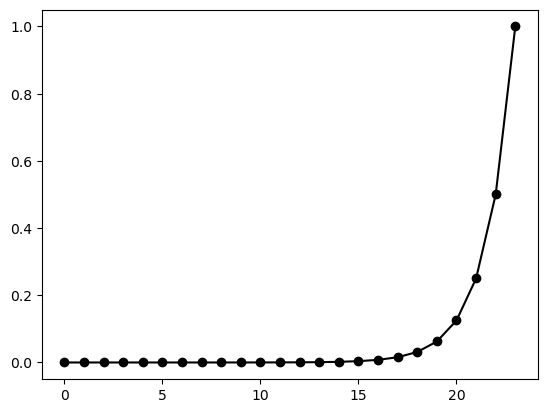

In [88]:
plt.plot(alphas, 'k-o')

In [91]:
df = pd.concat(dfs).reset_index(drop = True)

In [92]:
df

,Player,ID,Year,G,MP,PER,BPM,VORP
0,A.C. Green,greenac01,2000,82,1929,11.2,-0.3,0.8
1,A.J. Bramlett,bramlaj01,2000,8,61,-0.4,-15.9,-0.2
2,Aaron McKie,mckieaa01,2000,82,1952,13.2,1.2,1.5
3,Aaron Williams,williaa01,2000,81,1545,17.7,0.3,0.9
4,Adam Keefe,keefead01,2000,62,604,7.6,-4.0,-0.3
...,...,...,...,...,...,...,...,...
11514,Zach Collins,colliza01,2023,63,1441,16.4,-0.2,0.6
11515,Zach LaVine,lavinza01,2023,77,2768,19.0,1.9,2.7
11516,Zeke Nnaji,nnajize01,2023,53,728,12.5,-3.7,-0.3
11517,Ziaire Williams,willizi02,2023,37,561,7.4,-5.6,-0.5


In [98]:
df['PER'] = df['PER'].fillna(df['PER'].mean())

In [101]:
df.sort_values('pca')

,Player,ID,Year,G,MP,PER,BPM,VORP,pca
2986,Nenê,hilarne01,2006,1,3,-54.4,-70.7,0.0,-94.966468
3429,Mile Ilić,ilicmi01,2007,5,6,-48.6,-52.0,-0.1,-79.051870
8615,Mindaugas Kuzminskas,kuzmimi01,2018,1,2,-41.1,-54.7,0.0,-74.766128
3556,Von Wafer,wafervo01,2007,1,1,-40.7,-52.4,0.0,-73.054642
10813,Nate Hinton,hintona01,2022,2,2,-45.2,-42.6,0.0,-70.655175
...,...,...,...,...,...,...,...,...,...
4421,Steven Hill,hillst01,2009,1,2,88.3,29.2,0.0,78.207731
9303,Zhou Qi,qizh01,2019,1,1,80.4,52.0,0.0,85.816468
2367,Jackie Butler,butleja01,2005,3,5,90.3,55.7,0.1,95.879540
6411,DeAndre Liggins,liggide01,2014,1,1,129.1,41.5,0.0,117.849668


In [107]:
pca = PCA(n_components=1)
dfpca['pca'] = pca.fit_transform(dfpca[['PER', 'BPM', 'VORP']])

/var/folders/x8/gymrgfns32bd6rd_ksf19p3m0000gn/T/ipykernel_58205/458565911.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfpca['pca'] = pca.fit_transform(dfpca[['PER', 'BPM', 'VORP']])


In [111]:
dfpca.sort_values('pca', ascending=False).tail(20)

,Player,ID,Year,G,MP,PER,BPM,VORP,pca
436,Will Perdue,perduwi01,2000,67,1012,6.6,-5.3,-0.8,-10.201668
4882,Trenton Hassell,hassetr01,2010,52,1106,6.5,-5.3,-0.9,-10.312982
2857,Jason Collins,collija04,2006,71,1895,5.5,-3.8,-0.9,-10.412536
3775,Jeff McInnis,mcinnje01,2008,54,1410,6.5,-5.4,-1.2,-10.447454
5923,Dahntay Jones,jonesda02,2013,78,1016,6.4,-5.5,-0.9,-10.492541
1538,Junior Harrington,harriju01,2003,82,2003,6.4,-5.1,-1.6,-10.499408
10244,P.J. Tucker,tuckepj01,2021,52,1356,5.5,-4.1,-0.7,-10.500568
9570,Jordan Poole,poolejo01,2020,57,1274,7.2,-6.6,-1.5,-10.536467
3563,Yakhouba Diawara,diawaya01,2007,64,1177,5.3,-3.9,-0.6,-10.540265
6879,Dante Exum,exumda01,2015,82,1817,5.7,-4.3,-1.1,-10.546884


<Axes: >

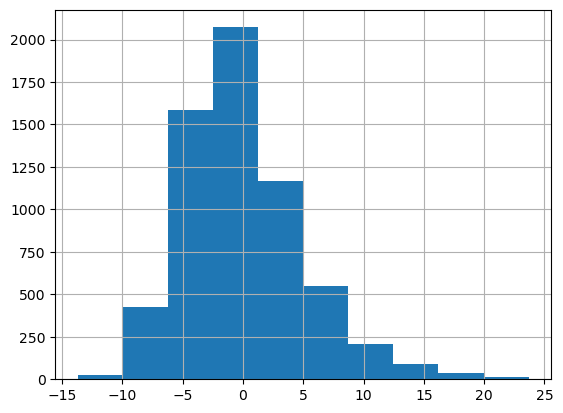

In [112]:
dfpca['pca'].hist()

<Axes: >

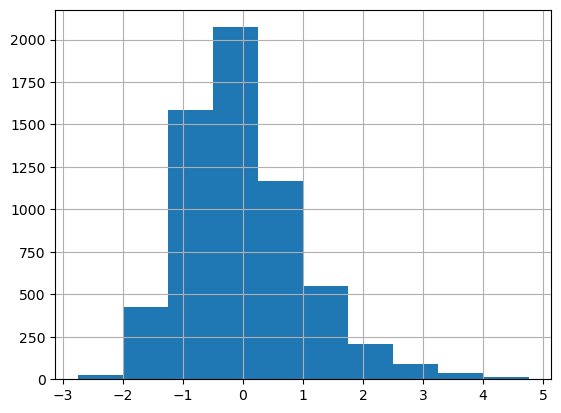

In [113]:
((dfpca['pca'] - dfpca['pca'].mean()) / dfpca['pca'].std()).hist()

<Axes: >

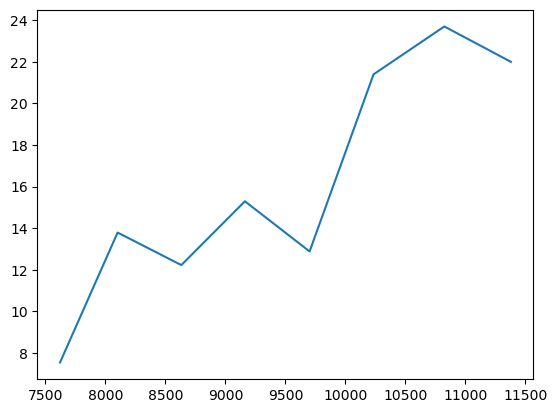

In [121]:
dfpca.groupby('ID').get_group('jokicni01').sort_values('Year').pca.plot()